# Notebook to process variants and their read count across conditions

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
from upsetplot import from_indicators
from upsetplot import UpSet

## Specify paths

In [2]:
### Input
rcdf_path = snakemake.input[0]

### Output
# Dataframes
selcoeffs_df_path = snakemake.output.selcoeffs
# Plots
hist_plot = snakemake.output.hist_plot
upset_plot = snakemake.output.upset_plot
rc_var_plot = snakemake.output.rc_var_plot
timepoints_plot = snakemake.output.timepoints_plot
replicates_plot = snakemake.output.replicates_plot
scoeff_violin_plot = snakemake.output.scoeff_violin_plot

## Specify parameters

In [3]:
# Columns in the sequence layout (dataframes of expected variants) related to mutations (should be invariable from one project to another)
mutation_attributes = ['pos','alt_codons','alt_aa','aa_pos','nt_seq','aa_seq','Nham_nt','Nham_aa','Nham_codons']

# Project-specific columns in the sample layout
sample_attributes = snakemake.params.sample_attributes

# Project-specific target for the read count per variant
exp_rc_per_var = snakemake.params.exp_rc_per_var

# Project-specific threshold to label variants with a confidence score
rc_threshold = snakemake.params.rc_threshold

# Projet-specific file containing the number of mitotic generations for each condition
nbgen_path = snakemake.params.nb_gen

## Import data

In [4]:
covered_df = pd.read_csv(rcdf_path, index_col=0, dtype={'WT': 'boolean', # Boolean type supports missing data
                                                             'pos':str, 'aa_pos':str}) # pos and aa_pos contain mixed types because of the nucleotide WT - very important when pivoting later on
covered_df

,Sample_name,Pos_start,Pos_stop,Mutated_seq,Species,Mating_type,Replicate,Fragment,Timepoint,nt_seq,...,pos,aa_pos,alt_codons,alt_aa,aa_seq,Nham_codons,Nham_nt,Nham_aa,readcount,Location
0,CN_a_r1_F1_T0,2.0,71.0,CN_F1,CN,a,r1,F1,T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,non-applicable,non-applicable,non-applicable,non-applicable,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,0.0,107428.0,both
1,CN_a_r2_F1_T0,2.0,71.0,CN_F1,CN,a,r2,F1,T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,non-applicable,non-applicable,non-applicable,non-applicable,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,0.0,100432.0,both
2,CN_alp_r1_F1_T0,2.0,71.0,CN_F1,CN,alp,r1,F1,T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,non-applicable,non-applicable,non-applicable,non-applicable,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,0.0,97993.0,both
3,CN_alp_r2_F1_T0,2.0,71.0,CN_F1,CN,alp,r2,F1,T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,non-applicable,non-applicable,non-applicable,non-applicable,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,0.0,179995.0,both
4,CN_a_r1_F1_T1,2.0,71.0,CN_F1,CN,a,r1,F1,T1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,non-applicable,non-applicable,non-applicable,non-applicable,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,0.0,51819.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420410,SC_alp_r2_F3_T3,92.0,158.0,SC_F3,SC,alp,r2,F3,T3,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,...,66,158,AAC,N,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1.0,2.0,1.0,6.0,both
420413,SC_alp_r2_F3_T3,92.0,158.0,SC_F3,SC,alp,r2,F3,T3,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,...,66,158,GAT,D,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1.0,1.0,1.0,8.0,both
420414,SC_alp_r2_F3_T3,92.0,158.0,SC_F3,SC,alp,r2,F3,T3,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,...,66,158,GAC,D,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1.0,1.0,1.0,552.0,both
420418,SC_alp_r2_F3_T3,92.0,158.0,SC_F3,SC,alp,r2,F3,T3,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,...,66,158,TGA,*,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1.0,2.0,1.0,51.0,both


## Add rows corresponding to variants not present in all replicates/timepoints

In [5]:
covered_df['TR'] = covered_df['Timepoint'] + '_' + covered_df['Replicate']
conditions = covered_df.TR.unique()
T0_conditions = [x for x in conditions if 'T0' in x]

In [6]:
upset = covered_df.pivot_table(index = sample_attributes + mutation_attributes,
                               columns='TR', values='readcount',
                               fill_value=0
                              ).reset_index(level=mutation_attributes)
upset

TR                                       pos      alt_codons          alt_aa  \
Species Mating_type Fragment                                                   
CN      a           F1                     0             AAA               K   
                    F1                     0             AAG               K   
                    F1                     0             AAT               N   
                    F1                     0             ACA               T   
                    F1                     0             ACC               T   
...                                      ...             ...             ...   
SC      alp         F3                     9             TTA               L   
                    F3                     9             TTC               F   
                    F3                     9             TTG               L   
                    F3                     9             TTT               F   
                    F3        non-applicable  non-applicable  non-applicable   

TR                                    aa_pos  \
Species Mating_type Fragment                   
CN      a           F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
...                                      ...   
SC      alp         F3                   101   
                    F3                   101   
                    F3                   101   
                    F3                   101   
                    F3        non-applicable   

TR                                                                       nt_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
...                                                                         ...   
SC      alp         F3        GACATGTGTACTGGTGCCATTATTATGTTAGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTCGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...   

TR                                                                       aa_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
...                                                                         ...   
SC      alp         F3        DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   

TR                            Nham_nt  Nham_aa  Nham_codons    T0_r1    T0_r2  \
Species Mating_type Fragment                                                    
CN      a   

## Filter low read count variants

In [7]:
def get_confidence_score(g, threshold):
    if (g >= threshold).all(): # Above threshold in all replicates
        return 1 # best confidence score
    elif (g >= threshold).any(): # Above threshold in at least 1 replicate
        return 2 # medium confidence score
    else:
        return 3 # low confidence score

In [8]:
upset['confidence_score'] = upset[T0_conditions].apply(lambda row: get_confidence_score(row, rc_threshold), axis=1)
mutation_attributes += ['confidence_score']
upset

TR                                       pos      alt_codons          alt_aa  \
Species Mating_type Fragment                                                   
CN      a           F1                     0             AAA               K   
                    F1                     0             AAG               K   
                    F1                     0             AAT               N   
                    F1                     0             ACA               T   
                    F1                     0             ACC               T   
...                                      ...             ...             ...   
SC      alp         F3                     9             TTA               L   
                    F3                     9             TTC               F   
                    F3                     9             TTG               L   
                    F3                     9             TTT               F   
                    F3        non-applicable  non-applicable  non-applicable   

TR                                    aa_pos  \
Species Mating_type Fragment                   
CN      a           F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
...                                      ...   
SC      alp         F3                   101   
                    F3                   101   
                    F3                   101   
                    F3                   101   
                    F3        non-applicable   

TR                                                                       nt_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
...                                                                         ...   
SC      alp         F3        GACATGTGTACTGGTGCCATTATTATGTTAGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTCGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...   

TR                                                                       aa_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
...                                                                         ...   
SC      alp         F3        DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   

TR                            Nham_nt  Nham_aa  Nham_codons    T0_r1    T0_r2  \
Species Mating_type Fragment                                                    
CN      a   

In [9]:
upset.reset_index().groupby(sample_attributes+['confidence_score'])[['nt_seq']].nunique()

TR                                             nt_seq
Species Mating_type Fragment confidence_score        
CN      a           F1       1                   4231
                             2                     31
                             3                     58
                    F2       1                   4210
                             2                     31
                             3                    101
                    F3       1                   3998
                             2                     38
                             3                    183
        alp         F1       1                   4157
                             2                     49
                             3                     96
                    F2       1                   4079
                             2                     52
                             3                    169
                    F3       1                   3953
                             2                     30
                             3                    219
SC      a           F1       1                   4055
                             2                     14
                             3                     60
                    F2       1                   4199
                             2                     45
                             3                     81
                    F3       1                   4114
                             2                     15
                             3                     39
        alp         F1       1                   3794
                             2                     29
                             3                    149
                    F2       1                   3947
                             2                     40
                             3                    170
                    F3       1                   3808
                             2                     28
                             3                    128

## Calculate frequencies

1. Variants with the lowest confidence score all filtered out
2. Read counts are normalized with the read depth for each sample
3. 1 is added to all counts and the frequency is log10-transformed

In [10]:
freq = upset.copy()
freq_conditions = [f'{x}_freq' for x in conditions]
T0_freq = [x for x in freq_conditions if 'T0' in x]

In [11]:
freq[freq_conditions] = freq[conditions].add(1) / freq.groupby(sample_attributes)[conditions].sum()
freq

TR                                       pos      alt_codons          alt_aa  \
Species Mating_type Fragment                                                   
CN      a           F1                     0             AAA               K   
                    F1                     0             AAG               K   
                    F1                     0             AAT               N   
                    F1                     0             ACA               T   
                    F1                     0             ACC               T   
...                                      ...             ...             ...   
SC      alp         F3                     9             TTA               L   
                    F3                     9             TTC               F   
                    F3                     9             TTG               L   
                    F3                     9             TTT               F   
                    F3        non-applicable  non-applicable  non-applicable   

TR                                    aa_pos  \
Species Mating_type Fragment                   
CN      a           F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
...                                      ...   
SC      alp         F3                   101   
                    F3                   101   
                    F3                   101   
                    F3                   101   
                    F3        non-applicable   

TR                                                                       nt_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
...                                                                         ...   
SC      alp         F3        GACATGTGTACTGGTGCCATTATTATGTTAGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTCGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...   

TR                                                                       aa_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
...                                                                         ...   
SC      alp         F3        DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   

TR                            Nham_nt  Nham_aa  Nham_codons    T0_r1  ...  \
Species Mating_type Fragment                                          ...   
CN      a           

In [12]:
# Retrieve overall mean frequency corresponding to the expected read count per variant
mean_exp_freq = (np.log10((exp_rc_per_var+1) / freq.groupby(sample_attributes)[conditions].sum())).mean(axis=None)

## Plot example of distribution of raw read count (per variant)

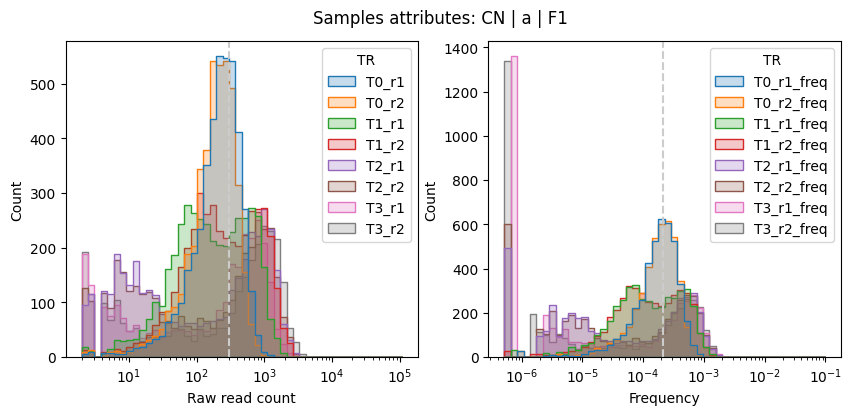

In [13]:
dataset1 = freq.index[0] # Just plotting for the first combination of sample attributes
graph1df = freq[conditions].loc[dataset1]
graph2df = freq[freq_conditions].loc[dataset1]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.histplot(graph1df, element='step', bins=50, common_norm=False, log_scale=10, ax=ax1)
ax1.axvline(x=exp_rc_per_var, linestyle='--', color='.8')
ax1.set(xlabel='Raw read count')

sns.histplot(graph2df, element='step', bins=50, log_scale=10, common_norm=False, ax=ax2)
ax2.axvline(x=10**mean_exp_freq, linestyle='--', color='.8')
ax2.set(xlabel='Frequency')

plt.subplots_adjust(top=.9)
plt.suptitle(f'Samples attributes: {" | ".join(dataset1)}')
plt.savefig(hist_plot, format='svg', dpi=300)

## Plot overlap across timepoints and replicates

In [14]:
freq['mean_input'] = freq[T0_freq].mean(axis=1)
bool_conditions = [f'{x}_indicator' for x in conditions]
freq[bool_conditions] = freq[conditions].astype(bool)
freq

TR                                       pos      alt_codons          alt_aa  \
Species Mating_type Fragment                                                   
CN      a           F1                     0             AAA               K   
                    F1                     0             AAG               K   
                    F1                     0             AAT               N   
                    F1                     0             ACA               T   
                    F1                     0             ACC               T   
...                                      ...             ...             ...   
SC      alp         F3                     9             TTA               L   
                    F3                     9             TTC               F   
                    F3                     9             TTG               L   
                    F3                     9             TTT               F   
                    F3        non-applicable  non-applicable  non-applicable   

TR                                    aa_pos  \
Species Mating_type Fragment                   
CN      a           F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
...                                      ...   
SC      alp         F3                   101   
                    F3                   101   
                    F3                   101   
                    F3                   101   
                    F3        non-applicable   

TR                                                                       nt_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
...                                                                         ...   
SC      alp         F3        GACATGTGTACTGGTGCCATTATTATGTTAGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTCGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...   

TR                                                                       aa_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
...                                                                         ...   
SC      alp         F3        DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   

TR                            Nham_nt  Nham_aa  Nham_codons    T0_r1  ...  \
Species Mating_type Fragment                                          ...   
CN      a           

In [15]:
upset_sub = freq.loc[dataset1] # Can be replaced with any specific combination of sample attributes
upset_sub

TR                                       pos      alt_codons          alt_aa  \
Species Mating_type Fragment                                                   
CN      a           F1                     0             AAA               K   
                    F1                     0             AAG               K   
                    F1                     0             AAT               N   
                    F1                     0             ACA               T   
                    F1                     0             ACC               T   
...                                      ...             ...             ...   
                    F1                     9             TTA               L   
                    F1                     9             TTC               F   
                    F1                     9             TTG               L   
                    F1                     9             TTT               F   
                    F1        non-applicable  non-applicable  non-applicable   

TR                                    aa_pos  \
Species Mating_type Fragment                   
CN      a           F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
...                                      ...   
                    F1                    11   
                    F1                    11   
                    F1                    11   
                    F1                    11   
                    F1        non-applicable   

TR                                                                       nt_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
...                                                                         ...   
                    F1        TCTCCTGTTGAAGGTTCTCCAGCTAAGTTAGAAGATTACCCACACT...   
                    F1        TCTCCTGTTGAAGGTTCTCCAGCTAAGTTCGAAGATTACCCACACT...   
                    F1        TCTCCTGTTGAAGGTTCTCCAGCTAAGTTGGAAGATTACCCACACT...   
                    F1        TCTCCTGTTGAAGGTTCTCCAGCTAAGTTTGAAGATTACCCACACT...   
                    F1        TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   

TR                                                                       aa_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
...                                                                         ...   
                    F1        SPVEGSPAKLEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        SPVEGSPAKFEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        SPVEGSPAKLEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        SPVEGSPAKFEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   

TR                            Nham_nt  Nham_aa  Nham_codons     T0_r1  ...  \
Species Mating_type Fragment                                           ...   
CN      a         

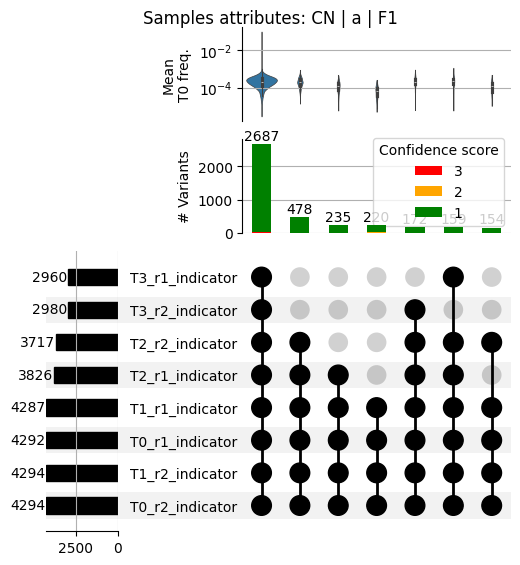

In [16]:
cscores = [1,2,3]
cscore_colors = ['green','orange','red']

fig = plt.figure(figsize=(6, 6))
upset_obj = UpSet(from_indicators(bool_conditions, data=upset_sub),
                   #show_percentages=True,
                   show_counts=True,
                   min_subset_size="1%",
                   sort_by='cardinality',
                   element_size=None,
                   intersection_plot_elements=0, # height of intersection barplot in matrix elements
                   totals_plot_elements = 2 # width of totals barplot in matrix elements
                  )

upset_obj.add_stacked_bars(by='confidence_score',
                           colors=dict(zip(cscores, cscore_colors)),
                           elements=3
                          )

upset_obj.add_catplot(value='mean_input', kind='violin', cut=0, density_norm='count',
                      log_scale=10, linewidth=0.5,
                      elements=3 # height in number of matrix elements
                      )

d = upset_obj.plot(fig=fig) # Assigns all plots to a dictionary containing axes subplots - same keys as gridspec returned by upset_obj.make_grid()
ax0 = d['extra0'] # Key corresponding to 1st stacked barplot - confidence score ('intersections' = intersection barplot)
ax1 = d['extra1'] # Key corresponding to 1st catplot - read count for input samples

ax0.set_ylabel('# Variants')
ax0.legend(title='Confidence score')

ax1.set_ylabel('Mean\nT0 freq.')

plt.subplots_adjust(top=.95)
plt.suptitle(f'Samples attributes: {" | ".join(dataset1)}')
plt.savefig(upset_plot, format='svg', dpi=300)

## Distribution of allele frequencies

In [17]:
longfreq = freq.melt(id_vars=mutation_attributes,
                     value_vars=freq_conditions, var_name='TR_freq',
                     value_name='frequency', ignore_index=False
                    ).reset_index()
longfreq

,Species,Mating_type,Fragment,pos,alt_codons,alt_aa,aa_pos,nt_seq,aa_seq,Nham_nt,Nham_aa,Nham_codons,confidence_score,TR_freq,frequency
0,CN,a,F1,0,AAA,K,2,AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,1.0,1.0,1,T0_r1_freq,1.439887e-05
1,CN,a,F1,0,AAG,K,2,AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,1.0,1.0,1,T0_r1_freq,1.439887e-05
2,CN,a,F1,0,AAT,N,2,AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,1.0,1.0,1,T0_r1_freq,2.278410e-04
3,CN,a,F1,0,ACA,T,2,ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,1.0,1.0,1,T0_r1_freq,1.719395e-04
4,CN,a,F1,0,ACC,T,2,ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,1.0,1.0,1,T0_r1_freq,4.150263e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403195,SC,alp,F3,9,TTA,L,101,GACATGTGTACTGGTGCCATTATTATGTTAGGTATCCCAAGATGTG...,DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,1.0,1.0,1,T3_r2_freq,8.431845e-07
403196,SC,alp,F3,9,TTC,F,101,GACATGTGTACTGGTGCCATTATTATGTTCGGTATCCCAAGATGTG...,DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1.0,1.0,1.0,1,T3_r2_freq,2.810615e-07
403197,SC,alp,F3,9,TTG,L,101,GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTG...,DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,1.0,1.0,1,T3_r2_freq,2.810615e-07
403198,SC,alp,F3,9,TTT,F,101,GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTG...,DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,1.0,1.0,1,T3_r2_freq,1.292883e-05


In [18]:
longfreq['Timepoint'] = longfreq.TR_freq.apply(lambda x: x.split('_')[0])
longfreq['Replicate'] = longfreq.TR_freq.apply(lambda x: x.split('_')[1])
longfreq

,Species,Mating_type,Fragment,pos,alt_codons,alt_aa,aa_pos,nt_seq,aa_seq,Nham_nt,Nham_aa,Nham_codons,confidence_score,TR_freq,frequency,Timepoint,Replicate
0,CN,a,F1,0,AAA,K,2,AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,1.0,1.0,1,T0_r1_freq,1.439887e-05,T0,r1
1,CN,a,F1,0,AAG,K,2,AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,1.0,1.0,1,T0_r1_freq,1.439887e-05,T0,r1
2,CN,a,F1,0,AAT,N,2,AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,1.0,1.0,1,T0_r1_freq,2.278410e-04,T0,r1
3,CN,a,F1,0,ACA,T,2,ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,1.0,1.0,1,T0_r1_freq,1.719395e-04,T0,r1
4,CN,a,F1,0,ACC,T,2,ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,1.0,1.0,1,T0_r1_freq,4.150263e-05,T0,r1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403195,SC,alp,F3,9,TTA,L,101,GACATGTGTACTGGTGCCATTATTATGTTAGGTATCCCAAGATGTG...,DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,1.0,1.0,1,T3_r2_freq,8.431845e-07,T3,r2
403196,SC,alp,F3,9,TTC,F,101,GACATGTGTACTGGTGCCATTATTATGTTCGGTATCCCAAGATGTG...,DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1.0,1.0,1.0,1,T3_r2_freq,2.810615e-07,T3,r2
403197,SC,alp,F3,9,TTG,L,101,GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTG...,DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,1.0,1.0,1,T3_r2_freq,2.810615e-07,T3,r2
403198,SC,alp,F3,9,TTT,F,101,GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTG...,DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,1.0,1.0,1,T3_r2_freq,1.292883e-05,T3,r2


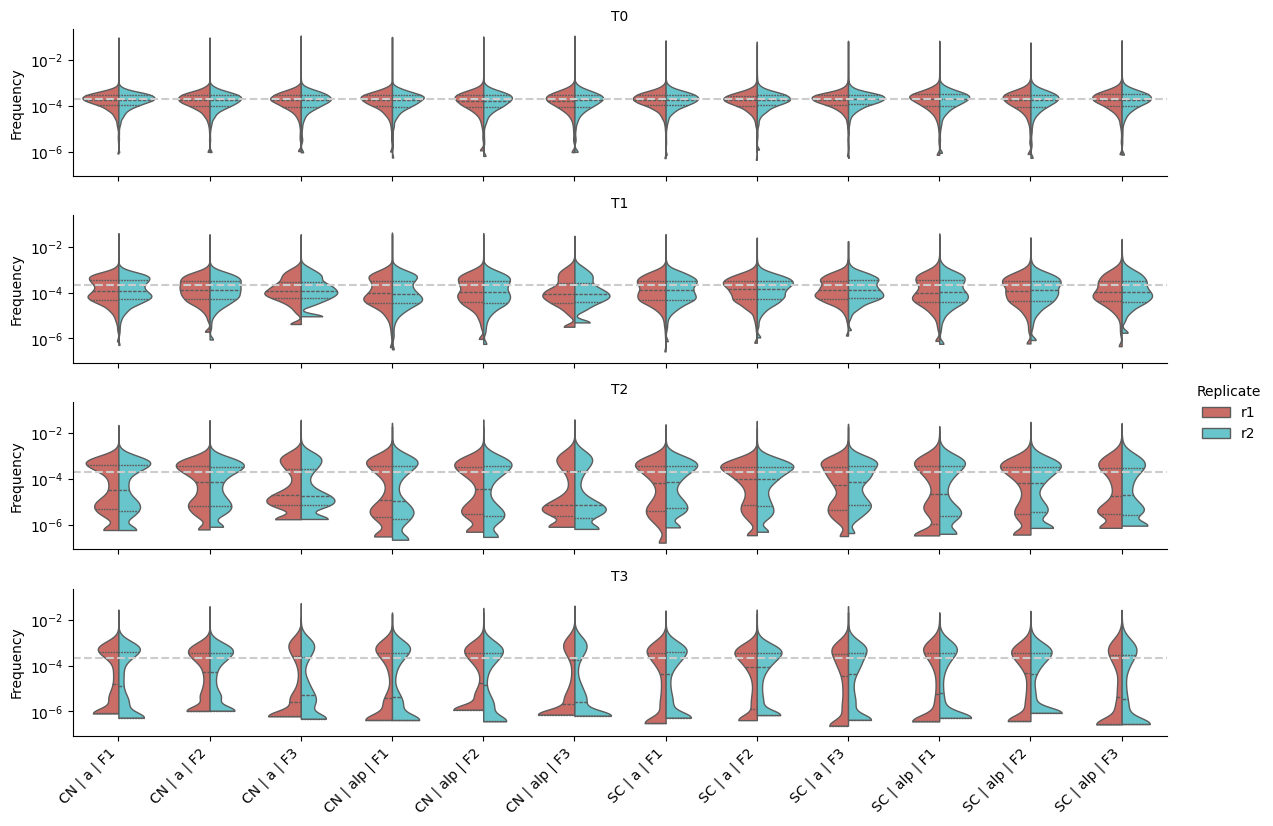

In [19]:
graphdf = longfreq.copy()
graphdf['Sample attributes'] = graphdf[sample_attributes].agg(' | '.join, axis=1)
labels = graphdf['Sample attributes'].unique()
g = sns.catplot(graphdf, x='Sample attributes', y='frequency', row='Timepoint',
            hue='Replicate', palette='hls', split=True,
            log_scale=10,
            kind='violin', cut=0, linewidth=1, inner='quart',
            height=2, aspect=.5*len(labels)
           )
g.map(plt.axhline, y=10**mean_exp_freq, linestyle='--', color='.8')

g.set_axis_labels('','Frequency')
g.set_titles(row_template='{row_name}')
g.set_xticklabels(labels, rotation=45, ha='right')
plt.savefig(rc_var_plot, format='svg', dpi=300)

## Get mutation type

In [20]:
def get_mutation_type(Nham_aa, alt_aa):
    # Quick function to determine if the mutation is synonymous or non-synonymous<
    # and if it's missense or nonsense
    if Nham_aa == 0:
        return 'synonymous'
    elif alt_aa == '*':
        return 'nonsense'
    else:
        return 'missense'

In [21]:
longfreq['mutation_type'] = longfreq.apply(lambda row: get_mutation_type(row.Nham_aa, row.alt_aa), axis=1)
mutation_attributes += ['mutation_type']
longfreq.head(4)

,Species,Mating_type,Fragment,pos,alt_codons,alt_aa,aa_pos,nt_seq,aa_seq,Nham_nt,Nham_aa,Nham_codons,confidence_score,TR_freq,frequency,Timepoint,Replicate,mutation_type
0,CN,a,F1,0,AAA,K,2,AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,1.0,1.0,1,T0_r1_freq,0.000014,T0,r1,missense
1,CN,a,F1,0,AAG,K,2,AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,1.0,1.0,1,T0_r1_freq,0.000014,T0,r1,missense
2,CN,a,F1,0,AAT,N,2,AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,1.0,1.0,1,T0_r1_freq,0.000228,T0,r1,missense
3,CN,a,F1,0,ACA,T,2,ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,1.0,1.0,1,T0_r1_freq,0.000172,T0,r1,missense


## Calculate Log2(fold-change) for every timepoint + final cumulative fold-change

In [22]:
freq_wide = longfreq.pivot(index=sample_attributes+mutation_attributes+['Replicate'],
                              columns='Timepoint',
                              values='frequency')
freq_wide

Timepoint                                                                                                                                                                                                                                                                  T0  \
Species Mating_type Fragment pos            alt_codons     alt_aa         aa_pos         nt_seq                                             aa_seq                                             Nham_nt Nham_aa Nham_codons confidence_score mutation_type Replicate             
CN      a           F1       0              AAA            K              2              AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACTT... KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSRI... 3.0     1.0     1.0         1                missense      r1         0.000014   
                                                                                                                                                                                                                                                          r2         0.000013   
                                            AAG            K              2              AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACTT... KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSRI... 3.0     1.0     1.0         1                missense      r1         0.000014   
                                                                                                                                                                                                                                                          r2         0.000035   
                                            AAT            N              2              AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACTT... NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSRI... 2.0     1.0     1.0         1                missense      r1         0.000228   
...                                                                                                                                                                                                                                                                       ...   
SC      alp         F3       9              TTG            L              101            GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTGT... DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERCK... 2.0     1.0     1.0         1                missense      r2         0.000328   
                                            TTT            F              101            GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTGT... DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERCK... 2.0     1.0     1.0         1                missense      r1         0.000241   
                                                                                                                                                                                                                                                          r2         0.000240   
                             non-applicable non-applicable non-applicable non-applicable GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTGT... DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERCK... 0.0     0.0     0.0         1                synonymous    r1         0.068868   
                                                                                                                                                                                                                                                          r2         0.073995   

Timepoint                                                                                                                                                                                                                                                                  T1  \
Species Mating_type Fragment pos            alt_codons     alt_aa         aa_pos         nt_seq                                             aa_seq                               

In [23]:
timepoints = [x for x in freq_wide.columns]
denom = ['T0'] + timepoints[:-1]
num = [timepoints[-1]] + timepoints[1:]
lfc_combinations = list(zip(num, denom))
lfc_combinations
lfc_cols = [f'Lfc_{"_".join(x)}' for x in lfc_combinations]
lfc_cols

['Lfc_T3_T0', 'Lfc_T1_T0', 'Lfc_T2_T1', 'Lfc_T3_T2']

In [24]:
lfc_combinations

[('T3', 'T0'), ('T1', 'T0'), ('T2', 'T1'), ('T3', 'T2')]

In [25]:
for i,v in enumerate(lfc_cols):
    freq_wide[v] = freq_wide.apply(lambda row: np.log2(row[lfc_combinations[i][0]] / row[lfc_combinations[i][1]]), axis=1)

freq_wide

Timepoint                                                                                                                                                                                                                                                                  T0  \
Species Mating_type Fragment pos            alt_codons     alt_aa         aa_pos         nt_seq                                             aa_seq                                             Nham_nt Nham_aa Nham_codons confidence_score mutation_type Replicate             
CN      a           F1       0              AAA            K              2              AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACTT... KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSRI... 3.0     1.0     1.0         1                missense      r1         0.000014   
                                                                                                                                                                                                                                                          r2         0.000013   
                                            AAG            K              2              AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACTT... KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSRI... 3.0     1.0     1.0         1                missense      r1         0.000014   
                                                                                                                                                                                                                                                          r2         0.000035   
                                            AAT            N              2              AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACTT... NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSRI... 2.0     1.0     1.0         1                missense      r1         0.000228   
...                                                                                                                                                                                                                                                                       ...   
SC      alp         F3       9              TTG            L              101            GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTGT... DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERCK... 2.0     1.0     1.0         1                missense      r2         0.000328   
                                            TTT            F              101            GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTGT... DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERCK... 2.0     1.0     1.0         1                missense      r1         0.000241   
                                                                                                                                                                                                                                                          r2         0.000240   
                             non-applicable non-applicable non-applicable non-applicable GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTGT... DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERCK... 0.0     0.0     0.0         1                synonymous    r1         0.068868   
                                                                                                                                                                                                                                                          r2         0.073995   

Timepoint                                                                                                                                                                                                                                                                  T1  \
Species Mating_type Fragment pos            alt_codons     alt_aa         aa_pos         nt_seq                                             aa_seq                               

## Normalize with number of mitotic generations

In [26]:
nbgen_df = pd.read_excel(nbgen_path)
nbgen_wide = nbgen_df.pivot(index=sample_attributes+['Replicate'],
                            columns='Timepoint',
                            values='Nb_gen'
                           )
nbgen_wide.columns = [f'{x}_gen' for x in nbgen_wide.columns]
nbgen_wide['Tot_gen'] = nbgen_wide.sum(axis=1)
nbgen_wide

T1_gen    T2_gen    T3_gen  \
Species Mating_type Fragment Replicate                                 
CN      a           F1       r1         4.868106  5.253252  5.375656   
                             r2         4.779851  5.104819  5.351195   
                    F2       r1         4.930749  5.277036  5.404861   
                             r2         4.967964  5.198671  5.329043   
                    F3       r1         4.898172  5.175425  5.286946   
                             r2         4.913619  5.068004  5.233917   
        alp         F1       r1         5.043224  5.331150  5.535205   
                             r2         5.043355  5.361786  5.398479   
                    F2       r1         5.135997  5.404580  5.477216   
                             r2         5.119450  5.391888  5.417810   
                    F3       r1         4.983051  5.346053  5.387940   
                             r2         4.991102  5.352388  5.441973   
SC      a           F1       r1         4.945900  5.281198  5.291668   
                             r2         5.028227  5.181917  5.258547   
                    F2       r1         4.937921  5.137975  5.277715   
                             r2         5.052079  5.204239  5.246741   
                    F3       r1         4.807419  5.193279  5.374301   
                             r2         4.935000  5.019813  5.321053   
        alp         F1       r1         5.082713  5.289300  5.473097   
                             r2         5.057634  5.332332  5.434153   
                    F2       r1         5.143444  5.397580  5.407276   
                             r2         5.071945  5.328495  5.455779   
                    F3       r1         4.958483  5.296219  5.377462   
                             r2         5.000597  5.315693  5.450477   

                                          Tot_gen  
Species Mating_type Fragment Replicate             
CN      a           F1       r1         15.497015  
                             r2         15.235865  
                    F2       r1         15.612646  
                             r2         15.495678  
                    F3       r1         15.360543  
                             r2         15.215541  
        alp         F1       r1         15.909579  
                             r2         15.803620  
                    F2       r1         16.017792  
                             r2         15.929148  
                    F3       r1         15.717043  
                             r2         15.785463  
SC      a           F1       r1         15.518766  
                             r2         15.468691  
                    F2       r1         15.353611  
                             r2         15.503058  
                    F3       r1         15.374999  
                             r2         15.275866  
        alp         F1       r1         15.845110  
                             r2         15.824119  
                    F2       r1         15.948301  
                             r2         15.856220  
                    F3       r1         15.632164  
                             r2         15.766767

In [27]:
lfc_wide = freq_wide.reset_index().merge(right=nbgen_wide.reset_index(), on=sample_attributes+['Replicate'])
gen_cols = [f'{x}_gen' for x in ['Tot'] + timepoints[1:]]
lfc_wide[gen_cols]

,Tot_gen,T1_gen,T2_gen,T3_gen
0,15.497015,4.868106,5.253252,5.375656
1,15.497015,4.868106,5.253252,5.375656
2,15.497015,4.868106,5.253252,5.375656
3,15.497015,4.868106,5.253252,5.375656
4,15.497015,4.868106,5.253252,5.375656
...,...,...,...,...
100795,15.766767,5.000597,5.315693,5.450477
100796,15.766767,5.000597,5.315693,5.450477
100797,15.766767,5.000597,5.315693,5.450477
100798,15.766767,5.000597,5.315693,5.450477


In [28]:
for x in list(zip(lfc_cols, gen_cols)):
    lfc_wide[x[0]] /= lfc_wide[x[1]]
lfc_wide

,Species,Mating_type,Fragment,pos,alt_codons,alt_aa,aa_pos,nt_seq,aa_seq,Nham_nt,...,T2,T3,Lfc_T3_T0,Lfc_T1_T0,Lfc_T2_T1,Lfc_T3_T2,T1_gen,T2_gen,T3_gen,Tot_gen
0,CN,a,F1,0,AAA,K,2,AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,...,2.399285e-06,8.161879e-07,-0.267207,-0.262676,-0.248711,-0.289384,4.868106,5.253252,5.375656,15.497015
1,CN,a,F1,0,AAG,K,2,AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,...,5.998214e-07,8.161879e-07,-0.267207,-0.302249,-0.592756,0.082663,4.868106,5.253252,5.375656,15.497015
2,CN,a,F1,0,AAT,N,2,AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,...,4.198750e-06,8.161879e-07,-0.524289,-0.398678,-0.727381,-0.439572,4.868106,5.253252,5.375656,15.497015
3,CN,a,F1,0,ACA,T,2,ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,...,7.197856e-06,8.161879e-07,-0.498082,-0.442917,-0.461052,-0.584225,4.868106,5.253252,5.375656,15.497015
4,CN,a,F1,0,ACC,T,2,ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,...,5.998214e-07,3.264752e-06,-0.236701,-0.482025,-0.716885,0.454711,4.868106,5.253252,5.375656,15.497015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100795,SC,alp,F3,9,TTA,L,101,GACATGTGTACTGGTGCCATTATTATGTTAGGTATCCCAAGATGTG...,DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,...,5.557609e-06,8.431845e-07,-0.516674,-0.287861,-0.749904,-0.499139,5.000597,5.315693,5.450477,15.766767
100796,SC,alp,F3,9,TTC,F,101,GACATGTGTACTGGTGCCATTATTATGTTCGGTATCCCAAGATGTG...,DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1.0,...,9.262681e-07,2.810615e-07,-0.628908,-0.436043,-1.131523,-0.315669,5.000597,5.315693,5.450477,15.766767
100797,SC,alp,F3,9,TTG,L,101,GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTG...,DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,...,7.410145e-06,2.810615e-07,-0.646101,-0.390763,-0.660747,-0.866079,5.000597,5.315693,5.450477,15.766767
100798,SC,alp,F3,9,TTT,F,101,GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTG...,DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,...,1.945163e-05,1.292883e-05,-0.267449,-0.333200,-0.368967,-0.108119,5.000597,5.315693,5.450477,15.766767


## Normalize with median of synonymous codons

In [29]:
syn = lfc_wide[(lfc_wide.Nham_nt >0) & (lfc_wide.Nham_aa == 0)][sample_attributes+['Replicate']+lfc_cols]
syn

,Species,Mating_type,Fragment,Replicate,Lfc_T3_T0,Lfc_T1_T0,Lfc_T2_T1,Lfc_T3_T2
8,CN,a,F1,r1,-0.438466,-0.316431,-0.550422,-0.439572
10,CN,a,F1,r1,-0.419559,-0.357609,-0.567840,-0.330755
51,CN,a,F1,r1,-0.462824,-0.524912,-0.963485,0.082663
52,CN,a,F1,r1,-0.184603,0.000282,-0.327717,-0.212178
53,CN,a,F1,r1,-0.510513,-0.435183,-0.885607,-0.212178
...,...,...,...,...,...,...,...,...
100542,SC,alp,F3,r2,-0.624457,-0.430620,-0.747176,-0.682609
100589,SC,alp,F3,r2,-0.678864,-0.494066,-0.926947,-0.606462
100629,SC,alp,F3,r2,-0.535510,-0.525023,-0.770792,-0.315669
100630,SC,alp,F3,r2,-0.594576,-0.527772,-0.943401,-0.315669


In [30]:
syn.describe()

,Lfc_T3_T0,Lfc_T1_T0,Lfc_T2_T1,Lfc_T3_T2
count,3956.000000,3956.000000,3956.000000,3956.000000
mean,-0.416596,-0.394863,-0.650530,-0.207580
std,0.154930,0.152665,0.323665,0.299497
min,-0.777878,-1.036720,-1.686230,-1.192245
25%,-0.526291,-0.475292,-0.852141,-0.416316
50%,-0.438135,-0.417243,-0.650615,-0.166505
75%,-0.334861,-0.340804,-0.462071,0.015693
max,0.261942,0.832081,0.713557,0.958751


In [31]:
mediansyn = syn.groupby(sample_attributes+['Replicate'])[lfc_cols].median()
mediansyn.columns = [x.replace('Lfc','med') for x in mediansyn.columns]
med_cols = mediansyn.columns
mediansyn

med_T3_T0  med_T1_T0  med_T2_T1  \
Species Mating_type Fragment Replicate                                    
CN      a           F1       r1         -0.431701  -0.390109  -0.661775   
                             r2         -0.469425  -0.392597  -0.693113   
                    F2       r1         -0.387017  -0.392695  -0.584016   
                             r2         -0.384607  -0.398447  -0.571022   
                    F3       r1         -0.431762  -0.297031  -0.516817   
                             r2         -0.387290  -0.259288  -0.553534   
        alp         F1       r1         -0.444777  -0.421764  -0.694819   
                             r2         -0.435887  -0.431129  -0.703799   
                    F2       r1         -0.377591  -0.441281  -0.636533   
                             r2         -0.452389  -0.465792  -0.664592   
                    F3       r1         -0.381681  -0.360898  -0.628212   
                             r2         -0.368151  -0.328870  -0.685446   
SC      a           F1       r1         -0.466990  -0.439247  -0.654918   
                             r2         -0.482487  -0.423889  -0.608704   
                    F2       r1         -0.496487  -0.459810  -0.631571   
                             r2         -0.463098  -0.457969  -0.648170   
                    F3       r1         -0.446787  -0.396230  -0.657768   
                             r2         -0.470996  -0.372103  -0.599572   
        alp         F1       r1         -0.484372  -0.461047  -0.749344   
                             r2         -0.490859  -0.434681  -0.690287   
                    F2       r1         -0.480159  -0.466554  -0.690758   
                             r2         -0.446420  -0.458203  -0.655081   
                    F3       r1         -0.486261  -0.431572  -0.712381   
                             r2         -0.478274  -0.430844  -0.660747   

                                        med_T3_T2  
Species Mating_type Fragment Replicate             
CN      a           F1       r1         -0.172047  
                             r2         -0.108479  
                    F2       r1         -0.110890  
                             r2         -0.078656  
                    F3       r1         -0.417303  
                             r2         -0.300017  
        alp         F1       r1         -0.142869  
                             r2         -0.078451  
                    F2       r1         -0.064674  
                             r2         -0.047104  
                    F3       r1         -0.078581  
                             r2         -0.006743  
SC      a           F1       r1         -0.233774  
                             r2         -0.367040  
                    F2       r1         -0.257864  
                             r2         -0.216011  
                    F3       r1         -0.211881  
                             r2         -0.383741  
        alp         F1       r1          0.014144  
                             r2         -0.302750  
                    F2       r1         -0.064882  
                             r2         -0.065153  
                    F3       r1         -0.271339  
                             r2         -0.315669

## Calculate selection coefficients

In [32]:
selcoeff_cols = [x.replace('Lfc','s') for x in lfc_cols]
s_wide = lfc_wide.merge(right=mediansyn.reset_index(), on=sample_attributes+['Replicate'])

In [33]:
for i,s in enumerate(selcoeff_cols):
    s_wide[s] = s_wide[lfc_cols[i]] - s_wide[med_cols[i]]
s_wide

,Species,Mating_type,Fragment,pos,alt_codons,alt_aa,aa_pos,nt_seq,aa_seq,Nham_nt,...,T3_gen,Tot_gen,med_T3_T0,med_T1_T0,med_T2_T1,med_T3_T2,s_T3_T0,s_T1_T0,s_T2_T1,s_T3_T2
0,CN,a,F1,0,AAA,K,2,AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,...,5.375656,15.497015,-0.431701,-0.390109,-0.661775,-0.172047,0.164494,0.127433,0.413063,-0.117338
1,CN,a,F1,0,AAG,K,2,AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,...,5.375656,15.497015,-0.431701,-0.390109,-0.661775,-0.172047,0.164494,0.087860,0.069018,0.254710
2,CN,a,F1,0,AAT,N,2,AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,...,5.375656,15.497015,-0.431701,-0.390109,-0.661775,-0.172047,-0.092588,-0.008569,-0.065607,-0.267525
3,CN,a,F1,0,ACA,T,2,ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,...,5.375656,15.497015,-0.431701,-0.390109,-0.661775,-0.172047,-0.066381,-0.052808,0.200723,-0.412178
4,CN,a,F1,0,ACC,T,2,ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,...,5.375656,15.497015,-0.431701,-0.390109,-0.661775,-0.172047,0.195000,-0.091916,-0.055110,0.626758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100795,SC,alp,F3,9,TTA,L,101,GACATGTGTACTGGTGCCATTATTATGTTAGGTATCCCAAGATGTG...,DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,...,5.450477,15.766767,-0.478274,-0.430844,-0.660747,-0.315669,-0.038400,0.142983,-0.089157,-0.183470
100796,SC,alp,F3,9,TTC,F,101,GACATGTGTACTGGTGCCATTATTATGTTCGGTATCCCAAGATGTG...,DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1.0,...,5.450477,15.766767,-0.478274,-0.430844,-0.660747,-0.315669,-0.150634,-0.005200,-0.470776,0.000000
100797,SC,alp,F3,9,TTG,L,101,GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTG...,DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,...,5.450477,15.766767,-0.478274,-0.430844,-0.660747,-0.315669,-0.167827,0.040081,0.000000,-0.550411
100798,SC,alp,F3,9,TTT,F,101,GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTG...,DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,...,5.450477,15.766767,-0.478274,-0.430844,-0.660747,-0.315669,0.210824,0.097644,0.291780,0.207550


## Calculate median selection coefficient (over synonymous mutants)

In [34]:
mutation_attributes_aa = [x for x in mutation_attributes if x not in ['alt_codons', 'nt_seq', 'Nham_nt', 'Nham_codons','confidence_score']]
mutation_attributes_aa

['pos', 'alt_aa', 'aa_pos', 'aa_seq', 'Nham_aa', 'mutation_type']

In [35]:
median_df = s_wide.groupby(sample_attributes+mutation_attributes_aa+['Replicate']
                          )[selcoeff_cols+['confidence_score']
                           ].agg(dict(zip(selcoeff_cols+['confidence_score'], ['median']*len(selcoeff_cols + ['min'])))
                                ).reset_index(mutation_attributes_aa)
median_df

pos          alt_aa  \
Species Mating_type Fragment Replicate                                   
CN      a           F1       r1                      0               *   
                             r2                      0               *   
                             r1                      0               A   
                             r2                      0               A   
                             r1                      0               C   
...                                                ...             ...   
SC      alp         F3       r2                      9               W   
                             r1                      9               Y   
                             r2                      9               Y   
                             r1         non-applicable  non-applicable   
                             r2         non-applicable  non-applicable   

                                                aa_pos  \
Species Mating_type Fragment Replicate                   
CN      a           F1       r1                      2   
                             r2                      2   
                             r1                      2   
                             r2                      2   
                             r1                      2   
...                                                ...   
SC      alp         F3       r2                    101   
                             r1                    101   
                             r2                    101   
                             r1         non-applicable   
                             r2         non-applicable   

                                                                                   aa_seq  \
Species Mating_type Fragment Replicate                                                      
CN      a           F1       r1         *PVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                             r2         *PVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                             r1         APVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                             r2         APVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                             r1         CPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
...                                                                                   ...   
SC      alp         F3       r2         DMCTGAIIMWGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                             r1         DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                             r2         DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                             r1         DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                             r2         DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   

                                        Nham_aa mutation_type   s_T3_T0  \
Species Mating_type Fragment Replicate                                    
CN      a           F1       r1             1.0      nonsense  0.511516   
                             r2             1.0      nonsense  0.564673   
                             r1             1.0      missense -0.016831   
                             r2             1.0      missense -0.007345   
                             r1             1.0      missense  0.182096   
...                                         ...           ...       ...   
SC      alp         F3       r2             1.0      missense -0.038182   
                             r1             0.0    synonymous  0.383243   
                             r2             0.0    synonymous  0.374235   
                             r1             0.0    synonymous  0.398165   
                             r2             0.0    synonymous  0.384516   

                                         s_T1_T0   s_T2_T1   s_T3_T2  \
Species Mating_type Fragment Replicate                                 
CN 

In [36]:
median_df.to_csv(selcoeffs_df_path)

## Plot example of correlation between compared timepoints

/tmp/ipykernel_4145/3063661726.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  graphdf = median_df.loc[dataset1_r1].reset_index()


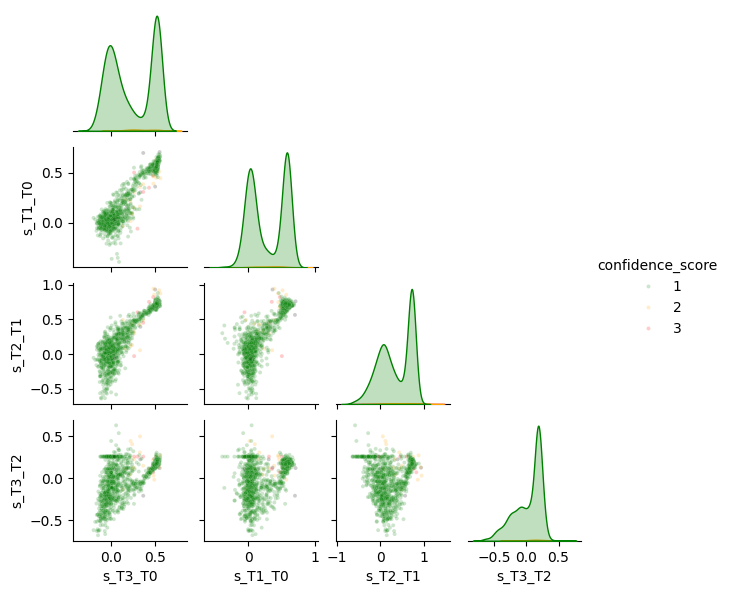

In [37]:
dataset1_r1 = median_df.index[0]
graphdf = median_df.loc[dataset1_r1].reset_index()
sns.pairplot(graphdf, vars=selcoeff_cols,
             hue='confidence_score', hue_order=cscores, palette=dict(zip(cscores, cscore_colors)),
             plot_kws={'s':8, 'alpha':.2},
             height=1.5, corner=True)
plt.savefig(timepoints_plot, format='svg', dpi=300)

## Show correlation between first two replicates

In [38]:
median_long = median_df.melt(id_vars=mutation_attributes_aa,
                        value_vars=selcoeff_cols, var_name='Compared timepoints',
                        value_name='s', ignore_index=False).reset_index()
median_long

,Species,Mating_type,Fragment,Replicate,pos,alt_aa,aa_pos,aa_seq,Nham_aa,mutation_type,Compared timepoints,s
0,CN,a,F1,r1,0,*,2,*PVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1.0,nonsense,s_T3_T0,0.511516
1,CN,a,F1,r2,0,*,2,*PVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1.0,nonsense,s_T3_T0,0.564673
2,CN,a,F1,r1,0,A,2,APVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1.0,missense,s_T3_T0,-0.016831
3,CN,a,F1,r2,0,A,2,APVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1.0,missense,s_T3_T0,-0.007345
4,CN,a,F1,r1,0,C,2,CPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1.0,missense,s_T3_T0,0.182096
...,...,...,...,...,...,...,...,...,...,...,...,...
139243,SC,alp,F3,r2,9,W,101,DMCTGAIIMWGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1.0,missense,s_T3_T2,-0.451232
139244,SC,alp,F3,r1,9,Y,101,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,0.0,synonymous,s_T3_T2,0.479889
139245,SC,alp,F3,r2,9,Y,101,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,0.0,synonymous,s_T3_T2,0.239553
139246,SC,alp,F3,r1,non-applicable,non-applicable,non-applicable,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,0.0,synonymous,s_T3_T2,0.444648


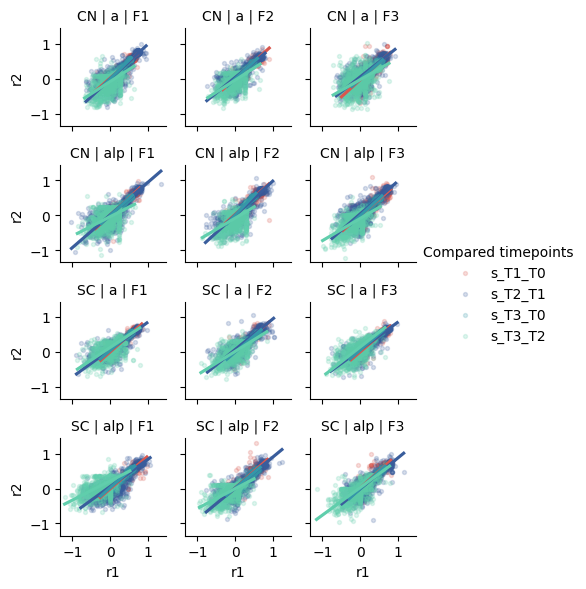

In [39]:
graphdf = median_long.pivot(index=sample_attributes+mutation_attributes_aa+['Compared timepoints'],
                            columns='Replicate',
                            values='s').reset_index()
graphdf['Sample attributes'] = graphdf[sample_attributes].agg(' | '.join, axis=1)
labels = graphdf['Sample attributes'].unique()
firstTwoReplicates = median_long.Replicate.unique()[:2]
pal = sns.color_palette('mako', n_colors=len(selcoeff_cols))
pal[0] = "#d9574e"

g = sns.lmplot(graphdf, x=firstTwoReplicates[0], y=firstTwoReplicates[1],
               col='Sample attributes', col_wrap=3,
               hue='Compared timepoints', palette=pal,
               height=1.5, scatter_kws={'s':8,'alpha':.2})
g.set_titles(col_template='{col_name}')
plt.savefig(replicates_plot, format='svg', dpi=300)

## Plot overall distribution of selection coefficients

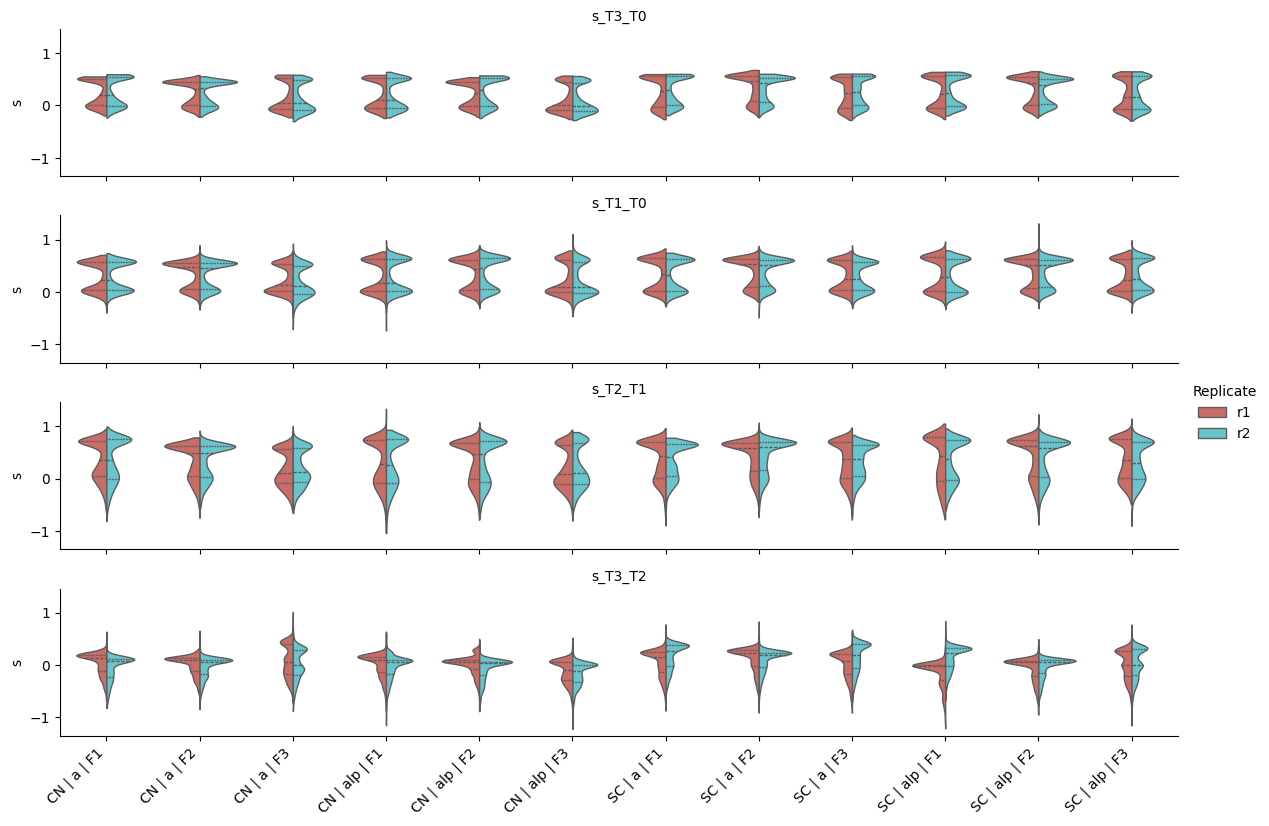

In [40]:
graphdf = median_long
graphdf['Sample attributes'] = graphdf[sample_attributes].agg(' | '.join, axis=1)
labels = graphdf['Sample attributes'].unique()
g = sns.catplot(graphdf, x='Sample attributes', y='s',
                row='Compared timepoints', row_order=selcoeff_cols,
                hue='Replicate', palette='hls', split=True,
                kind='violin', cut=0, linewidth=1, inner='quart',
                height=2, aspect=.5*len(labels)
               )

g.set_axis_labels('','s')
g.set_titles(row_template='{row_name}')
g.set_xticklabels(labels, rotation=45, ha='right')
plt.savefig(scoeff_violin_plot, format='svg', dpi=300)